In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

In [2]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

In [3]:
# Check and handle missing values
print(df.info())
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [4]:
# RFM feature engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
customer_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalPrice': 'sum'})

In [5]:
# Rename the features
customer_df.rename(columns={'InvoiceDate': 'recency',
                            'InvoiceNo': 'frequency',
                            'TotalPrice': 'monetary'}, inplace=True)

In [6]:
# Normalize the RFM features
scaler = MinMaxScaler()
norm_customer = scaler.fit_transform(customer_df)

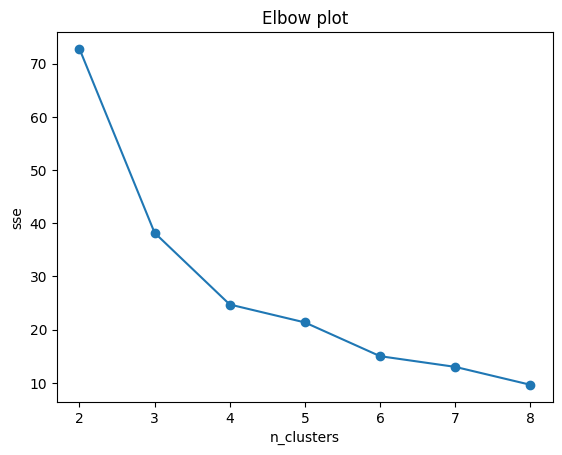

In [7]:
# Determine the optimal number of clusters
sse = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(norm_customer)
    sse.append(kmeans.inertia_)
plt.plot(range(2, 9), sse, marker='o')
plt.title('Elbow plot')
plt.xlabel('n_clusters')
plt.ylabel('sse')
plt.show()

In [8]:
# Silhouette analysis
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(norm_customer)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(norm_customer, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7278424265360027
For n_clusters=3, the silhouette score is 0.6585539108730682
For n_clusters=4, the silhouette score is 0.5794718614919225
For n_clusters=5, the silhouette score is 0.5705866997071363
For n_clusters=6, the silhouette score is 0.5792202304607106
For n_clusters=7, the silhouette score is 0.5349411818979787
For n_clusters=8, the silhouette score is 0.4637406596134261


In [12]:
# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(norm_customer)

KMeans(n_clusters=2, n_init=10)

In [13]:
# Assign cluster labels to each customer
customer_df['cluster'] = kmeans.labels_

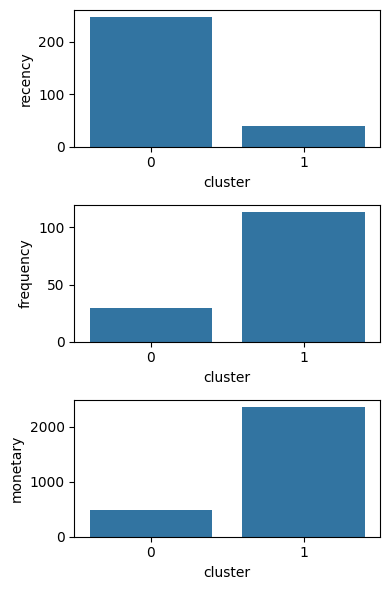

cluster
1    3290
0    1082
Name: count, dtype: int64


In [14]:
# Visualize the clusters
cluster_mean = customer_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()
fig, axes = plt.subplots(nrows=3, figsize=(4, 6))
sns.barplot(cluster_mean, x='cluster', y='recency', ax=axes[0])
sns.barplot(cluster_mean, x='cluster', y='frequency', ax=axes[1])
sns.barplot(cluster_mean, x='cluster', y='monetary', ax=axes[2])
plt.tight_layout()
plt.show()

print(customer_df['cluster'].value_counts())